## Transformers Self-Attention Mechanism (Visualization)

Introduced in 2017 by researchers from Google and the University of Toronto in their seminal paper [Attention is All You Need](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html), the Transformer has become a cornerstone of modern Natural Language Processing (NLP). This innovative encoder-decoder architecture was aimed at reducing sequencial computation (to speed-up training time). And has found wide application in tasks such as machine translation, reading comprehension, abstractive summarization, and text classification.

The core contribution of the Transformer is the use of a self-attention mechanism (while replacing RNNs). This allows the model to learn the relevance and context of all words (tokens) in an input, regardless of their position. It achieves this through attention weights (learned during the training phase) that determine the importance of each word to one another (irrespectively of their position).

In essence, the attention mechanism transforms a set of vectors from an initial dimensional space into a more nuanced representation better suited for downstream tasks. For language processing, this initial space might be word embeddings capturing basic semantic properties. The attention mechanism then enriches this representation, leading to improved accuracy, computational efficiency, and a clearer understanding of information flow compared to traditional Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs), which process input sequentially and do not have a way to explicitly consider the relationships between words.

The concept of attention in NLP isn't entirely new. It was first introduced to enhance sequence-to-sequence models in the 2014 paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) by Bahdanau, Cho, and Bengio. Their work allowed models "*to automatically (soft-)search for parts of a source sentence that are relevant to predicting a target word*". However, the Transformer took this concept further, replacing RNNs entirely with attention mechanisms and introducing multi-head attention. This enables the model to focus on various types of relationships simultaneously, marking a significant leap forward in NLP capabilities.

In this notebook we will explore this mechanism using [bertviz](https://pypi.org/project/bertviz/), an interactive tool for visualizing attention in Transformer models.

<p align="center">
  <img src="./static/self_attention_transformer_architecture.png" width="400">
</p>

<p align="center">The Transformer Architecture (source: https://arxiv.org/pdf/1706.03762.pdf)</p>

In [3]:
%pip install bertviz transformers --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import head_view, model_view
from bertviz.neuron_view import show
from bertviz.transformers_neuron_view import BertModel

utils.logging.set_verbosity_error()  # Suppress standard warnings

#### 1. Self-Attention in Practice

The intuition behind ``self-attention`` is that **averaging token embeddings instead of using a fixed embedding for each token, enables the model to capture how words relate to each other in the input**. In practice, said weighted relationships (attention weights) represent the syntactic and contextual structure of the sentence, leading to a more nuanced and rich understanding of the data.

#### 1.1 Implementing Self-Attention

The most common way to implement a self-attention layer relies on ``scaled dot-product attention``, and involves:
1. ``Linear projection`` of each token embedding into three vectors: ``query (q)``, ``key (k)``, ``value (v)``.
2. Compute ``scaled attention scores``: determine the similary between ``q`` and ``k`` by applying the ``dot product``. Since the results of this function are typically large numbers, they are then divided by a scaling factor inferred from the dimensionality of (k). This scaling contributes to stabilize gradients during training.
3. Normalize the ``attention scores`` into ``attention weights`` by applying the ``softmax`` function (this ensures all the values sum to 1).
4. ``Update the token embeddings`` by multiplying the ``attention weights`` by the ``value vector``.

> In addition, the self-attention mechanism of the decoder layer introduces ``masking`` to prevent the decoder from having access to future tokens in the sequence it is generating. In practice, this is implemented with a binary mask that designates which tokens should be attended to (assigned non-zero weights) and which should be ignored (assigned zero weights). In our function, setting the future tokens (upper values) to negative-infinity guarantees that the attention weights become zero after applying the softmax function (e exp -inf == 0). This design aligns with the nature of many tasks like translation, summarization, or text generation, where the output sequence needs to be generated one element at a time, and the prediction of each element should be based only on the previously generated elements.


```python
class AttentionHead(nn.Module):
    """
    Represents a single attention head within a multi-head attention mechanism.
    
    Args:
        config (TransformerConfig): The configuration for the transformer model.
    """
    def __init__(self, config):
        super().__init__()
        self.d_head = config.d_model // config.n_head

        self.q = nn.Linear(config.d_model, self.d_head)
        self.k = nn.Linear(config.d_model, self.d_head)
        self.v = nn.Linear(config.d_model, self.d_head)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        dim_k = torch.tensor(k.size(-1), dtype=torch.float32)
        attn_scores = torch.bmm(q, k.transpose(1, 2)) / torch.sqrt(dim_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = torch.softmax(attn_scores, axis=-1)
        output = torch.bmm(attn_weights, v)
        return output

    def forward(self, q, k, v, mask=None):
        """
        Args:
            q (torch.Tensor): query embeddings.
            k (torch.Tensor): key embeddings.
            v (torch.Tensor): value embeddings.
            mask (torch.Tensor): attention mask.
        """
        output = self.scaled_dot_product_attention(self.q(q), 
                                                   self.k(k), 
                                                   self.v(v), 
                                                   mask=mask)
        return output
```

#### 1.2 Implementing Multi-Head Attention

In a standard attention mechanism, the ``softmax`` of a single head tends to concentrate on a specific aspect of similarity, potentially overlooking other relevant features in the input. By integrating multiple attention heads, the model gains the ability to simultaneously attend to various aspects of the input data.

The basic approach to implement Multi-Headed Attention comprises:

1. Initialize the ``attention heads``. E.g. BERT has 12 attention heads whereas the embeddings dimension is 768, resulting in 768 / 12 = 64 as the head dimension.
2. ``Concatenate attention heads`` to combines the outputs of the attention heads into a single vector while preserving the dimensionality of the embeddings.
3. Apply a ``linear projection``.

> Note that the softmax function is a probability distribution, which when applied within a single attention head tends to amplify certain features (those with higher scores) while diminishing others. Thus, leading to a focus on specific aspects of similarity.


```python
class MultiHeadAttention(nn.Module):
    """
    Implements the Multi-Head Attention mechanism.

    Args:
        config (TransformerConfig): The configuration for the transformer model.
    """
    def __init__(self, config):
        super().__init__()
        assert config.d_model % config.n_head == 0, "d_model must be divisible by n_head"

        self.heads = nn.ModuleList([AttentionHead(config) for _ in range(config.n_head)])
        self.linear = nn.Linear(config.d_model, config.d_model)

    def forward(self, q, k, v, mask=None):
        attn_outputs = torch.cat([h(q, k, v, mask) for h in self.heads], dim=-1)
        output = self.linear(attn_outputs)
        return output
```

#### 1.3 Tokenization

We will use the `BERT-base-uncase` model to explore said attention mechanism at head and layer levels with two sentences.

In [5]:
model_type = 'bert'
model_version = 'bert-base-uncased'

In [6]:
sentence_a = "leaves fall in autumn"
sentence_b = "autumn is marked by colorful foliage"

When tokenizing these sentences we can observe the special tokens [CLS] and [SEP], which help the model understand the structure of the input: 
- The [CLS] token is at the beginning, indicating the start of the sequence.
- The first [SEP] token separates two sentences: "leaves fall in autumn" and "autumn is marked by colorful foliage".
- The second [SEP] token marks the end of the entire input sequence.

In [7]:
model = AutoModel.from_pretrained(model_version, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)

/usr/local/python/3.10.13/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
tokens

['[CLS]',
 'leaves',
 'fall',
 'in',
 'autumn',
 '[SEP]',
 'autumn',
 'is',
 'marked',
 'by',
 'colorful',
 'foliage',
 '[SEP]']

In [9]:
attention = model(**inputs).attentions
len(attention), attention[0].shape

(12, torch.Size([1, 12, 13, 13]))

### 2. Multi-heads

BERT actually learns multiple attention mechanisms, called heads, which operate in parallel to one another. Because the attention heads do not share parameters, each head learns a unique attention pattern. The version of BERT that we consider here — BERT Base — has 12 layers and 12 heads, resulting in a total of 12 x 12 = 144 distinct attention mechanisms (heads). We can visualize attention in all of the heads at once, using `model view`.

In [10]:
sentence_b_start = inputs['token_type_ids'][0].tolist().index(1)
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

#### 2.1 Learned Patterns

- Syntactic relationships: e.g. subject-verb or noun-adjective relationships, which helps the model understand the grammatical structure of sentences.
- Semantic relationships: understand the meaning and associations between different terms.
- Coreference resolution: learn to associate pronouns with their corresponding antecedents, allowing it to correctly interpret sentences with references to previously mentioned entities.
- Word order and sentence structure: allowing the model to capture the order and hierarchy of phrases and clauses.
- Long-range dependencies: capture dependencies between distant words in a sentence.
- Contextual nuances: such as sarcasm, irony, or sentiment, by attending to specific words or phrases that carry such meaning.

**Attention to the Next Word:**

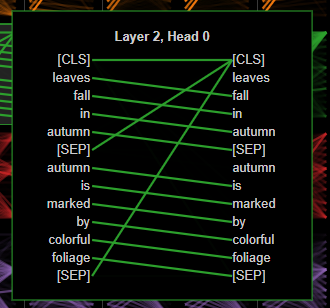

**Attention to Previous Word:**

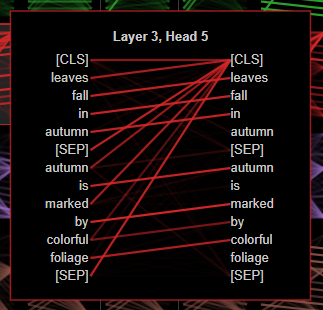

**Attention to Identical/Related Words:**

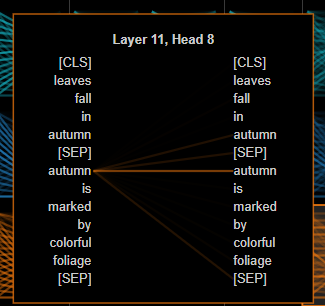

**Attention Noun-Noun:**

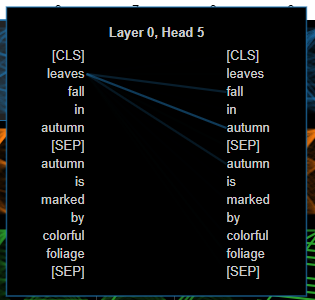

**Attention Subject-Verb:**

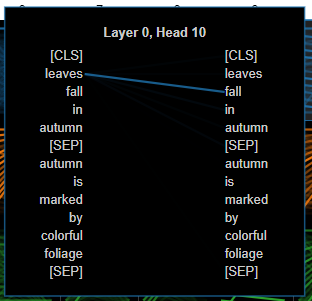

**Attention to End of Sentence(s):**

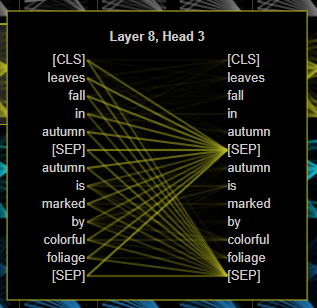

### 3. Head View

This shows how attention flows between tokens:

![Self Attention Head View](./static/self_attention_head_view.png)

In [11]:
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

### 4. Neuron View

We can visualize how attention weights are computed from query and key vectors using the neuron view.

**Query q**: encodes the word on the left that is paying attention, i.e. the one that is “querying” the other words.

**Key k**: encodes the word on the right to which attention is being paid. The key vector and the query vector together determine a compatibility score between the two words.

**q×k (elementwise)**: the elementwise product between the query vector of the selected word and each of the key vectors. This is a precursor to the dot product (the sum of the elementwise product) and is included for visualization purposes because it shows how individual elements in the query and key vectors contribute to the dot product.

**q·k**: the scaled dot product (see above) of the selected query vector and each of the key vectors. This is the unnormalized attention score.

**Softmax**: the softmax of the scaled dot product. This normalizes the attention scores to be positive and sum to one.

As an example, in layer 0 and head 5, when given the sentence **the morning sun cast a warm `light` through the window**, the attention mechanism will transform the dimenstional space of the word *`light`* into a new dimensional space where *`light`* is closer to the words *`sun`* and *`window`* (closer words results in higher dot product values);

![Attention S1](./static/self_attention_s1.png)

whereas in the sentence **she travels `light` for her weekend**, the word *`light`* would be represented closer to *`travel`*.

![Attention S2](./static/self_attention_s2.png)

In [17]:
text = "the morning sun cast a warm light through the window"
show(model, model_type, tokenizer, text, display_mode="light", layer=0, head=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>